# COVID-19 数据分析：时间趋势与模式

本 notebook 将分析 COVID-19 的时间趋势和模式，主要研究以下问题：
1. 不同国家/地区的 COVID-19 病例和死亡数量如何随时间变化？
2. 感染率是否存在季节性趋势（例如冬季高峰）？
3. 时间序列预测模型（如 ARIMA、Prophet）能否预测未来的疫情爆发？

## 1. 数据准备与导入

In [29]:
# 导入所需库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# 导入自定义工具函数
from covid_analysis_utils import *

# 设置中文字体
setup_chinese_fonts()

# 设置绘图风格
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

In [30]:
# 加载并预处理数据
df = load_and_preprocess_data()
print(f"数据集大小: {df.shape}")
df.head()

数据集大小: (429435, 72)


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,year,month,day,week,quarter
0,AFG,Asia,Afghanistan,2020-01-05,0.0,0.0,NaN,0.0,0.0,NaN,...,41128772,NaN,NaN,NaN,NaN,2020,1,5,1,1
1,AFG,Asia,Afghanistan,2020-01-06,0.0,0.0,NaN,0.0,0.0,NaN,...,41128772,NaN,NaN,NaN,NaN,2020,1,6,2,1
2,AFG,Asia,Afghanistan,2020-01-07,0.0,0.0,NaN,0.0,0.0,NaN,...,41128772,NaN,NaN,NaN,NaN,2020,1,7,2,1
3,AFG,Asia,Afghanistan,2020-01-08,0.0,0.0,NaN,0.0,0.0,NaN,...,41128772,NaN,NaN,NaN,NaN,2020,1,8,2,1
4,AFG,Asia,Afghanistan,2020-01-09,0.0,0.0,NaN,0.0,0.0,NaN,...,41128772,NaN,NaN,NaN,NaN,2020,1,9,2,1


## 2. 数据清洗与准备

In [31]:
# 数据清洗
df_clean = clean_data(df)

原始数据形状: (429435, 72)
缺失值比例:
weekly_icu_admissions                      97.440125
weekly_icu_admissions_per_million          97.440125
excess_mortality_cumulative_per_million    96.877059
excess_mortality_cumulative_absolute       96.877059
excess_mortality_cumulative                96.877059
                                             ...    
new_deaths_per_million                      4.384133
total_deaths                                4.105627
total_cases                                 4.105627
total_deaths_per_million                    4.105627
total_cases_per_million                     4.105627
Length: 63, dtype: float64

清洗后数据形状: (429435, 72)


In [32]:
# 筛选主要国家/地区
major_countries = ['China', 'United States', 'India', 'Brazil', 'United Kingdom', 
                  'Russia', 'France', 'Germany', 'Italy', 'Japan']
major_df = get_countries_data(df_clean, major_countries)

# 检查每个国家的数据量
major_df['location'].value_counts()

location
India             1682
Italy             1677
China             1674
Brazil            1674
Germany           1674
France            1674
Japan             1674
Russia            1674
United Kingdom    1674
United States     1674
Name: count, dtype: int64

In [33]:
# 计算每个月的全球汇总数据
global_data = df_clean[df_clean['location'] == 'World'].copy()


In [34]:
global_data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,year,month,day,week,quarter
422729,OWID_WRL,NaN,World,2020-01-05,2.0,2.0,NaN,3.0,3.0,NaN,...,7975105024,NaN,NaN,NaN,NaN,2020,1,5,1,1
422730,OWID_WRL,NaN,World,2020-01-06,2.0,0.0,NaN,3.0,0.0,NaN,...,7975105024,NaN,NaN,NaN,NaN,2020,1,6,2,1
422731,OWID_WRL,NaN,World,2020-01-07,2.0,0.0,NaN,3.0,0.0,NaN,...,7975105024,NaN,NaN,NaN,NaN,2020,1,7,2,1
422732,OWID_WRL,NaN,World,2020-01-08,2.0,0.0,NaN,3.0,0.0,NaN,...,7975105024,NaN,NaN,NaN,NaN,2020,1,8,2,1
422733,OWID_WRL,NaN,World,2020-01-09,2.0,0.0,NaN,3.0,0.0,NaN,...,7975105024,NaN,NaN,NaN,NaN,2020,1,9,2,1


In [35]:
global_monthly = summarize_by_date(global_data, freq='M')
global_monthly.head()

,date,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,year,month,day,week,quarter
0,2020-01-31,OWID_WRL,None,World,4.997778e+02,75.296296,80.035000,17.148148,2.296296,2.357727,...,7.975105e+09,NaN,NaN,NaN,NaN,2020.0,1.0,18.0,3.296296,1.0
1,2020-02-29,OWID_WRL,None,World,4.819507e+04,2628.068966,2637.407931,1339.620690,83.068966,83.346552,...,7.975105e+09,NaN,NaN,NaN,NaN,2020.0,2.0,15.0,7.275862,1.0
2,2020-03-31,OWID_WRL,None,World,2.245771e+05,19732.483871,13253.609032,10228.451613,1154.806452,744.040645,...,7.975105e+09,NaN,NaN,NaN,NaN,2020.0,3.0,16.0,11.580645,1.0
3,2020-04-30,OWID_WRL,None,World,1.718987e+06,67930.733333,69480.161667,127781.033333,5962.866667,5964.378333,...,7.975105e+09,NaN,NaN,NaN,NaN,2020.0,4.0,15.5,15.933333,2.0
4,2020-05-31,OWID_WRL,None,World,4.149737e+06,102046.806452,86869.468710,310798.032258,5946.258065,5432.939677,...,7.975105e+09,NaN,NaN,NaN,NaN,2020.0,5.0,16.0,20.258065,2.0


## 3. 不同国家/地区的 COVID-19 病例和死亡数量随时间变化

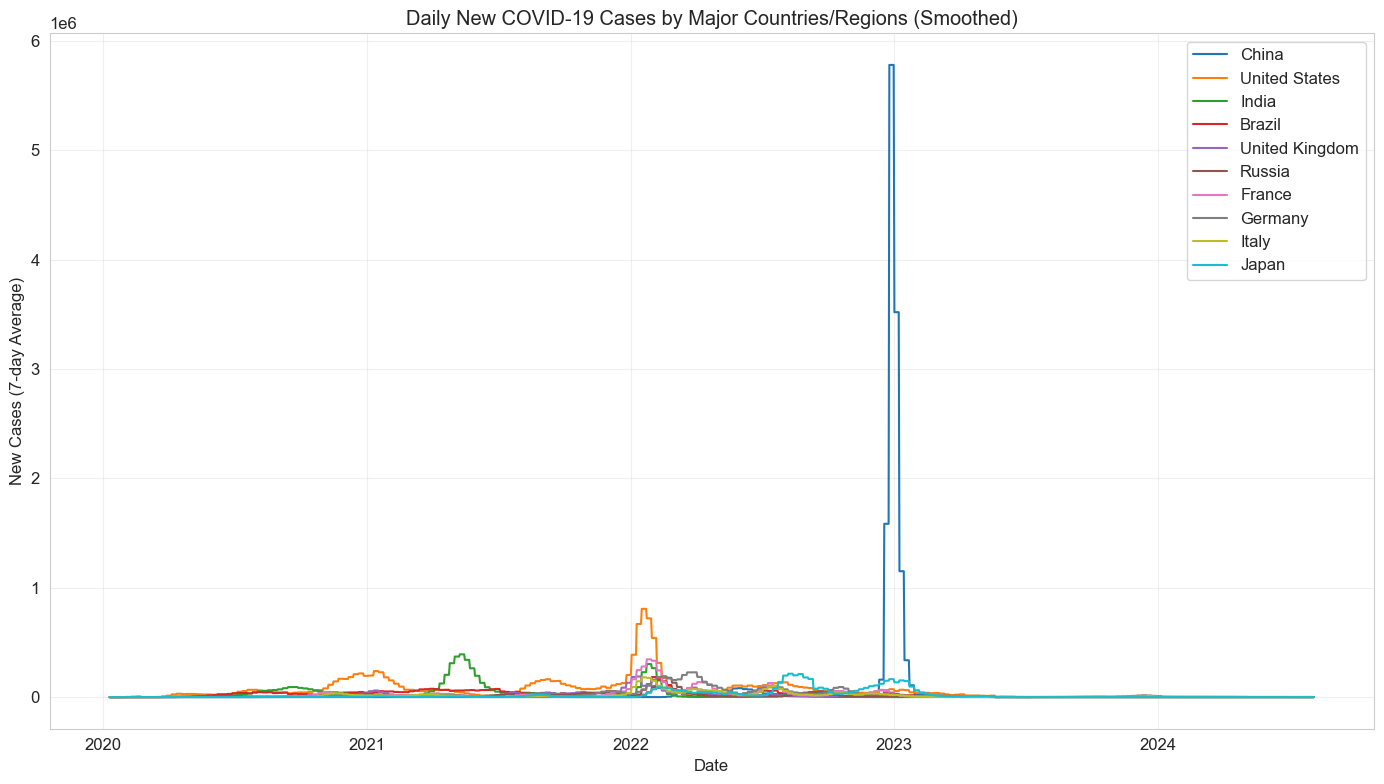

In [36]:
# 绘制主要国家日新增病例随时间变化的趋势
plt.figure(figsize=(14, 8))
for country in major_countries:
    country_data = major_df[major_df['location'] == country]
    plt.plot(country_data['date'], country_data['new_cases_smoothed'], label=country)

plt.title('Daily New COVID-19 Cases by Major Countries/Regions (Smoothed)')
plt.xlabel('Date')
plt.ylabel('New Cases (7-day Average)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [39]:
country_data['new_cases_smoothed'].isna().value_counts()

new_cases_smoothed
False    1669
True        5
Name: count, dtype: int64

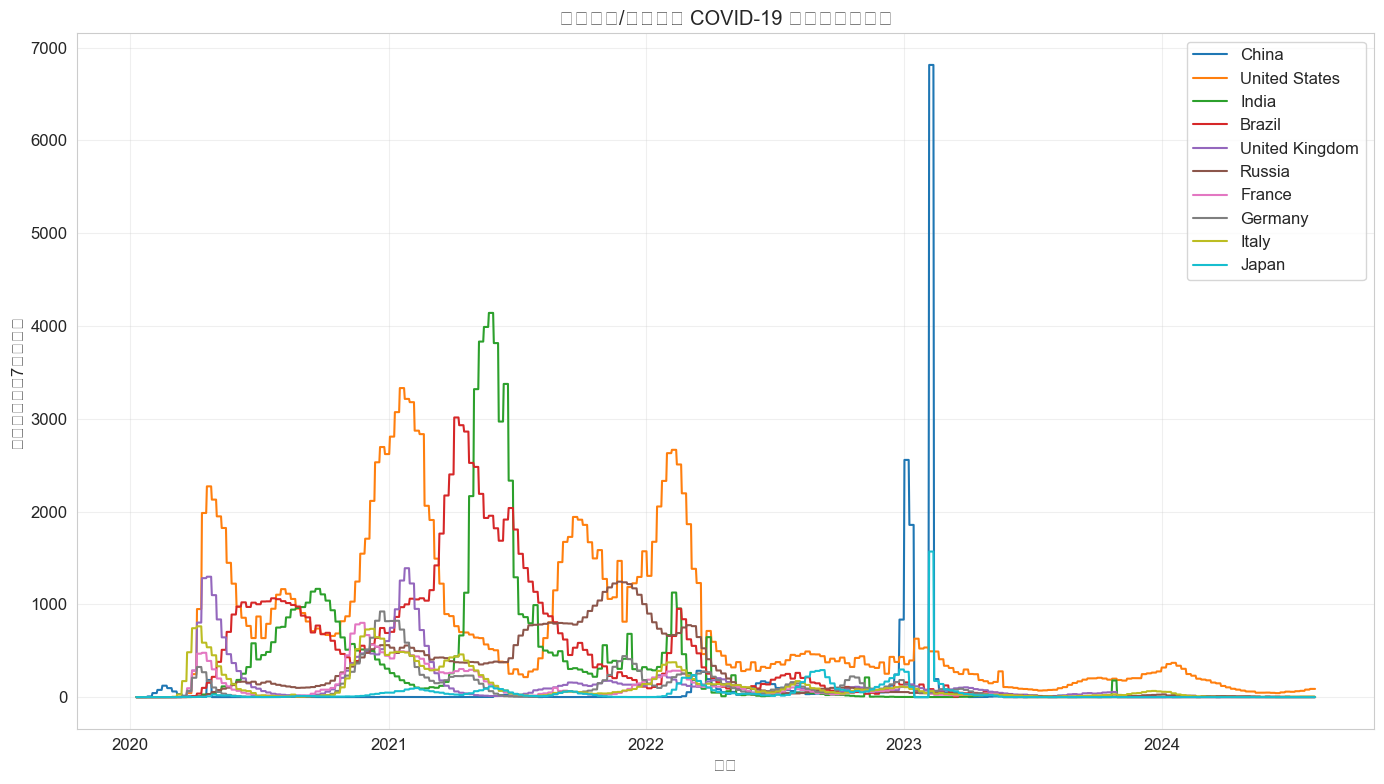

In [40]:
# 绘制主要国家日死亡数随时间变化的趋势
plt.figure(figsize=(14, 8))
for country in major_countries:
    country_data = major_df[major_df['location'] == country]
    plt.plot(country_data['date'], country_data['new_deaths_smoothed'], label=country)

plt.title('主要国家/地区每日 COVID-19 死亡数（平滑）')
plt.xlabel('日期')
plt.ylabel('新增死亡数（7日平均）')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

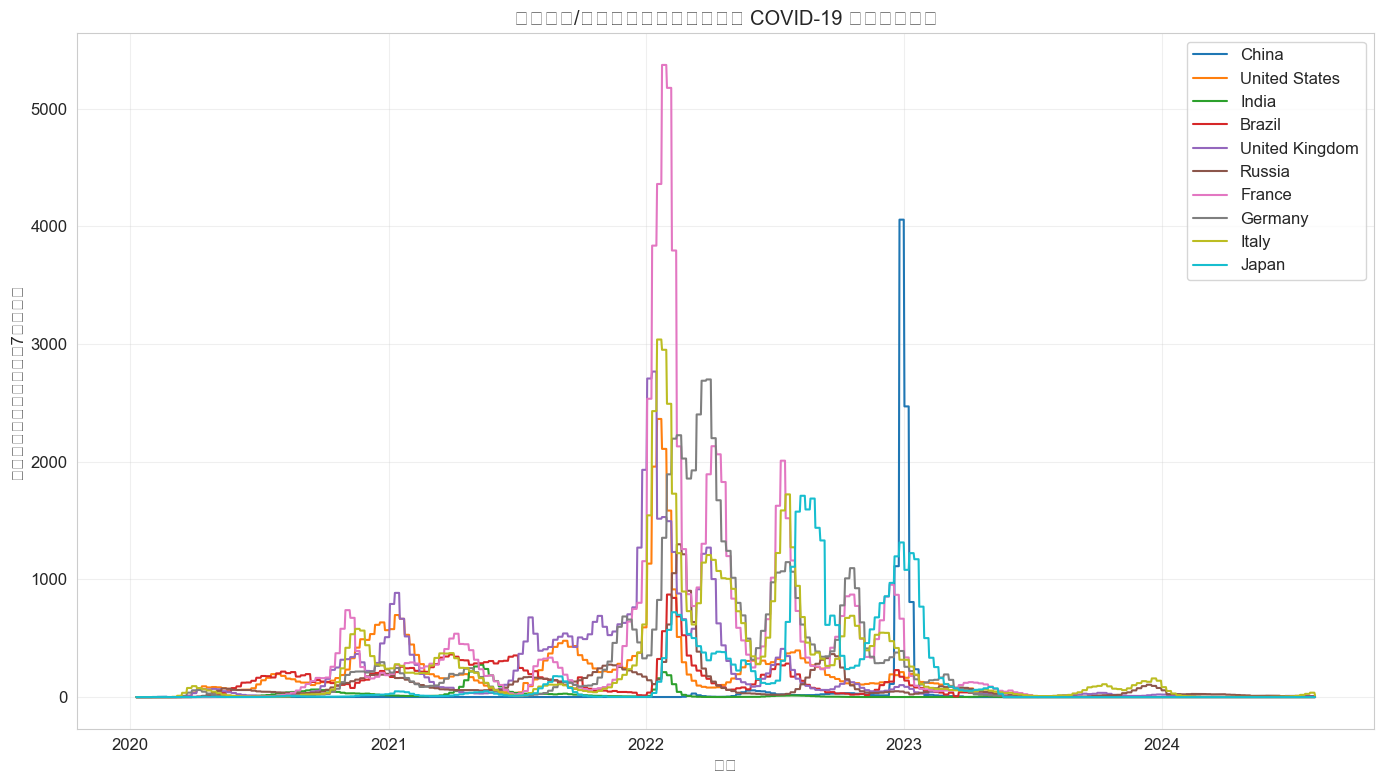

In [41]:
# 计算每百万人口病例数和死亡数，以便更公平地比较不同人口规模的国家
plt.figure(figsize=(14, 8))
for country in major_countries:
    country_data = major_df[major_df['location'] == country]
    plt.plot(country_data['date'], country_data['new_cases_smoothed_per_million'], label=country)

plt.title('主要国家/地区每百万人口每日新增 COVID-19 病例（平滑）')
plt.xlabel('日期')
plt.ylabel('每百万人口新增病例数（7日平均）')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

## 4. 感染率的季节性趋势分析

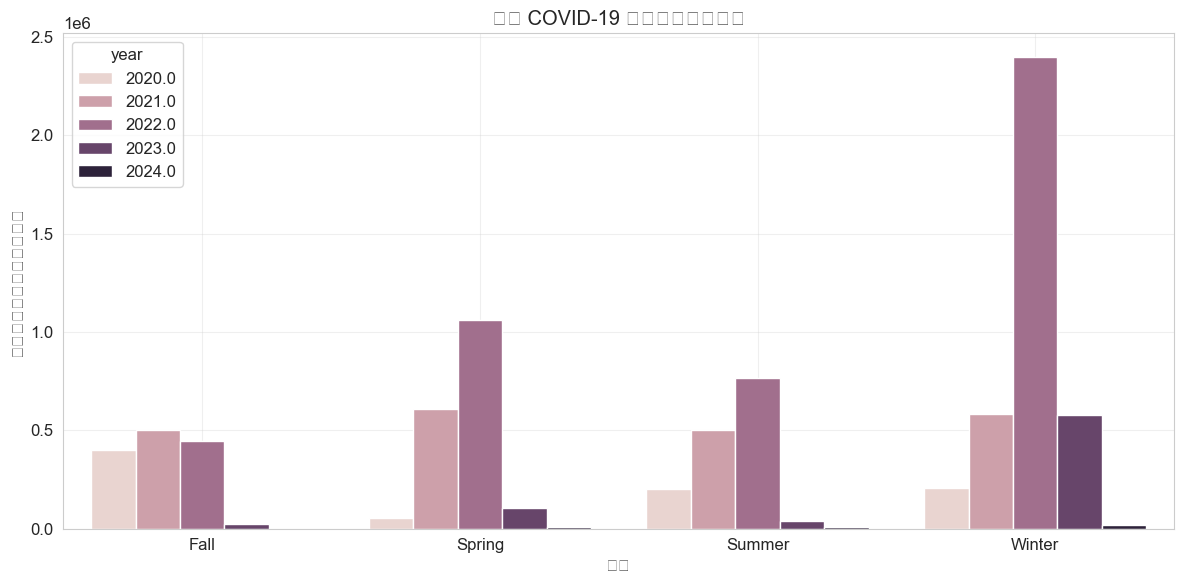

In [42]:
# 全球每月新增病例分析
global_monthly['month_name'] = global_monthly['date'].dt.month_name()
global_monthly['season'] = global_monthly['month'].apply(lambda x: 
                                                       'Winter' if x in [12, 1, 2] else
                                                       'Spring' if x in [3, 4, 5] else
                                                       'Summer' if x in [6, 7, 8] else 'Fall')

# 按年份和月份汇总
seasonal_data = global_monthly.groupby(['year', 'season'])['new_cases_smoothed'].mean().reset_index()
seasonal_data = seasonal_data[seasonal_data['year'] >= 2020]  # 只保留2020年之后的数据

# 绘制季节性趋势
plt.figure(figsize=(12, 6))
sns.barplot(x='season', y='new_cases_smoothed', hue='year', data=seasonal_data)
plt.title('全球 COVID-19 感染的季节性趋势')
plt.xlabel('季节')
plt.ylabel('平均每日新增病例（平滑）')
plt.grid(True, alpha=0.3)
plt.tight_layout()

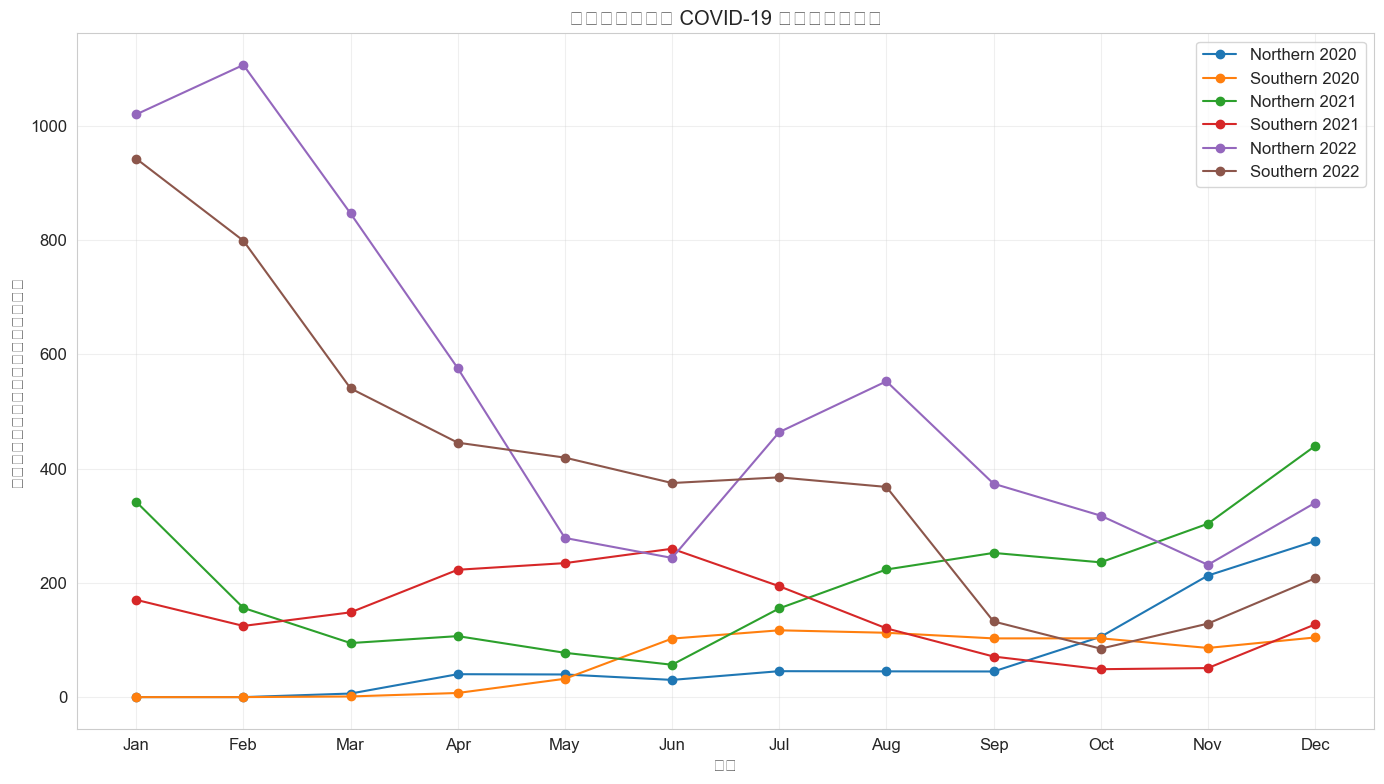

In [43]:
# 北半球和南半球的季节性对比
# 选择北半球代表国家
northern_countries = ['United States', 'United Kingdom', 'Germany', 'Russia', 'Japan']
# 选择南半球代表国家
southern_countries = ['Brazil', 'Australia', 'South Africa', 'Argentina', 'Chile']

# 获取数据
northern_df = get_countries_data(df_clean, northern_countries)
southern_df = get_countries_data(df_clean, southern_countries)

# 按月汇总
northern_monthly = northern_df.groupby(['year', 'month'])['new_cases_smoothed_per_million'].mean().reset_index()
southern_monthly = southern_df.groupby(['year', 'month'])['new_cases_smoothed_per_million'].mean().reset_index()

# 添加半球标签
northern_monthly['hemisphere'] = 'Northern'
southern_monthly['hemisphere'] = 'Southern'

# 合并数据
hemispheres_data = pd.concat([northern_monthly, southern_monthly])

# 只保留完整的年份数据
hemispheres_data = hemispheres_data[hemispheres_data['year'].isin([2020, 2021, 2022])]

# 绘制对比图
plt.figure(figsize=(14, 8))
for year in [2020, 2021, 2022]:
    for hemisphere in ['Northern', 'Southern']:
        data = hemispheres_data[(hemispheres_data['year'] == year) & 
                               (hemispheres_data['hemisphere'] == hemisphere)]
        plt.plot(data['month'], data['new_cases_smoothed_per_million'], 
                label=f'{hemisphere} {year}', marker='o')

plt.title('北半球与南半球 COVID-19 感染季节性对比')
plt.xlabel('月份')
plt.ylabel('每百万人口平均每日新增病例（平滑）')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

## 5. 时间序列预测模型

In [44]:
# 选择一个国家进行时间序列预测分析（以美国为例）
us_data = get_country_data(df_clean, 'United States')
us_data = us_data.sort_values('date')
print(us_data['new_cases_smoothed'].isna().value_counts())
# 提取感兴趣的时间序列
ts_data = us_data.set_index('date')['new_cases_smoothed']


new_cases_smoothed
False    1227
True      447
Name: count, dtype: int64


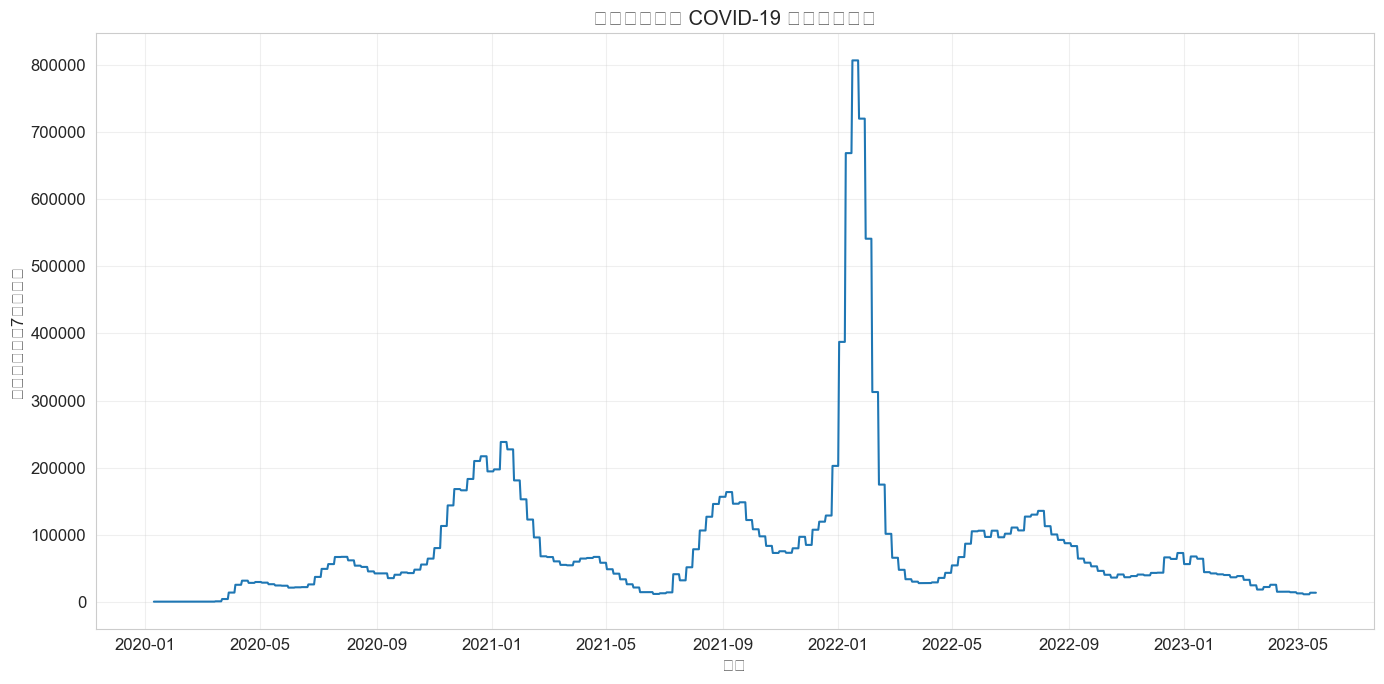

In [45]:
# 绘制原始时间序列
plt.figure(figsize=(14, 7))
plt.plot(ts_data.index, ts_data.values)
plt.title('美国每日新增 COVID-19 病例（平滑）')
plt.xlabel('日期')
plt.ylabel('新增病例数（7日平均）')
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [46]:

# 填充缺失值
ts_data_filled = ts_data.fillna(method='ffill').fillna(method='bfill')

# 划分训练集和测试集
train_size = int(len(ts_data_filled) * 0.9)
train_data = ts_data_filled[:train_size]
test_data = ts_data_filled[train_size:]

print(f"训练集大小: {len(train_data)}")
print(f"测试集大小: {len(test_data)}")

训练集大小: 1506
测试集大小: 168


In [48]:
ts_data_filled

date
2020-01-05        0.00
2020-01-06        0.00
2020-01-07        0.00
2020-01-08        0.00
2020-01-09        0.00
                ...   
2024-07-31    13322.86
2024-08-01    13322.86
2024-08-02    13322.86
2024-08-03    13322.86
2024-08-04    13322.86
Name: new_cases_smoothed, Length: 1674, dtype: float64

In [49]:
# 拟合ARIMA模型
# 这里简单使用ARIMA(5,1,1)作为示例，实际应用中应通过AIC、BIC等方法选择最佳参数
# import warnings
# warnings.filterwarnings('ignore')

# model = fit_arima_model(train_data, order=(5, 1, 1))
# print(model.summary())
# 对数据进行对数转换

# 检查数据的平稳性

from statsmodels.tsa.stattools import adfuller

# 对时间序列数据进行对数转换
ts_data_log = np.log1p(ts_data)
ts_data_log_clean = ts_data_log.dropna()

# 进行ADF检验
result = adfuller(ts_data_log_clean)
print('ADF统计量:', result[0])
print('p值:', result[1])

# 如果数据存在季节性，使用SARIMA模型
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(ts_data_log_clean,
                order=(1,1,1),  # 简化非季节性参数
                seasonal_order=(1,1,1,7),  # 保持周季节性
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

# # 如果SARIMA效果仍不理想，可以尝试Prophet模型
# # 对数据进行对数转换
# ts_data_log = np.log1p(ts_data)

# # 检查数据的平稳性
# from statsmodels.tsa.stattools import adfuller
# # 删除任何NaN值
# ts_data_log_clean = ts_data_log.dropna()
# result = adfuller(ts_data_log_clean)
# print('ADF统计量:', result[0])
# print('p值:', result[1])

# from prophet import Prophet
# df_prophet = pd.DataFrame({
#     'ds': ts_data_log_clean.index,
#     'y': ts_data_log_clean.values
# })
# model = Prophet(yearly_seasonality=False,
#                weekly_seasonality=True,
#                daily_seasonality=False)
# results = model.fit(df_prophet)

print(results.summary())

ADF统计量: -4.5232640109022295
p值: 0.0001784582395338089
                                     SARIMAX Results                                     
Dep. Variable:                new_cases_smoothed   No. Observations:                 1227
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                1024.944
Date:                           Wed, 19 Mar 2025   AIC                          -2039.889
Time:                                   22:38:34   BIC                          -2014.397
Sample:                               01-10-2020   HQIC                         -2030.290
                                    - 05-20-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1      -4.407e-05    100.335  -4.39e-07      1.000    -196.652  

In [50]:
forecast = results.forecast(steps=len(test_data))

In [51]:
forecast

2023-05-21     9.586721
2023-05-22     9.586721
2023-05-23     9.586721
2023-05-24     9.586721
2023-05-25     9.586721
                ...    
2023-10-31    12.735475
2023-11-01    12.735475
2023-11-02    12.735475
2023-11-03    12.735475
2023-11-04    12.735475
Freq: D, Name: predicted_mean, Length: 168, dtype: float64

In [ ]:
test_data

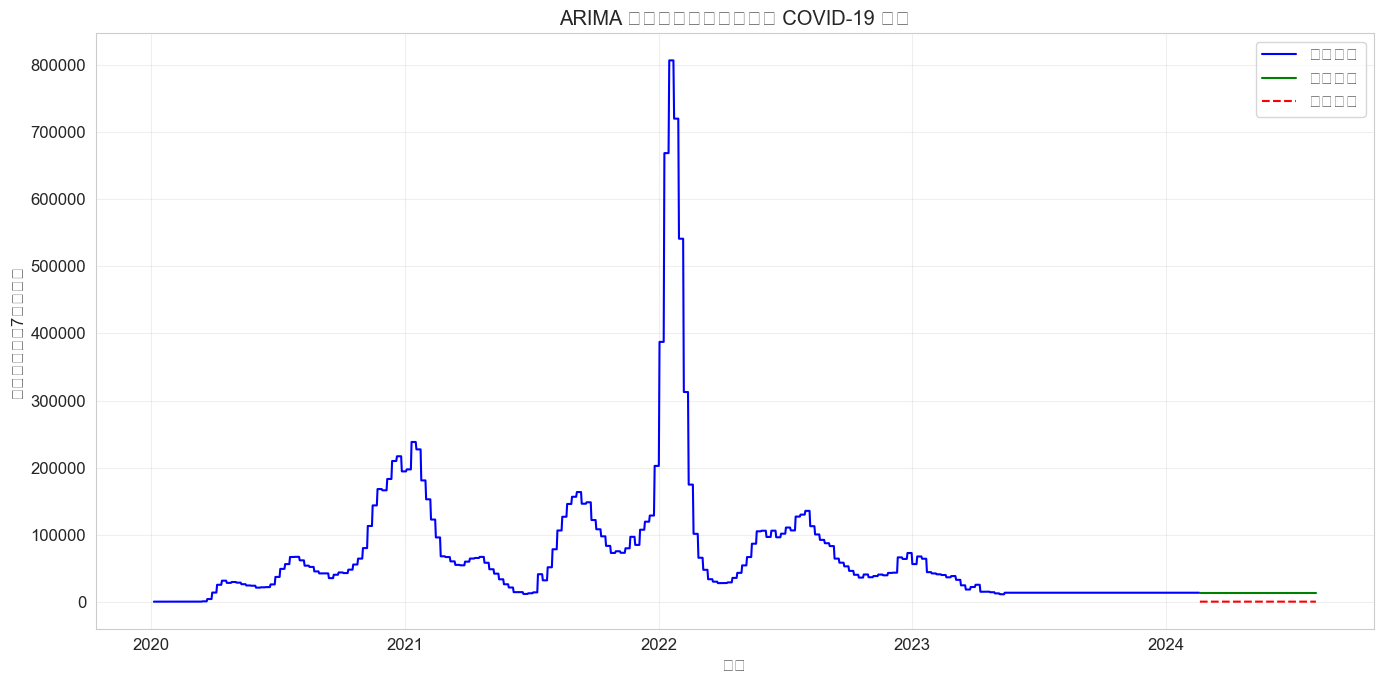

In [58]:
# 可视化预测结果
plt.figure(figsize=(14, 7))

# 绘制训练集
plt.plot(train_data.index, train_data.values, label='训练数据', color='blue')

# 绘制测试集
plt.plot(test_data.index, test_data.values, label='实际数据', color='green')

# 绘制预测值 - 使用predicted_mean而不是values
plt.plot(test_data.index, forecast.predicted_mean, label='预测数据', color='red', linestyle='--')

plt.title('ARIMA 模型预测美国每日新增 COVID-19 病例')
plt.xlabel('日期')
plt.ylabel('新增病例数（7日平均）')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

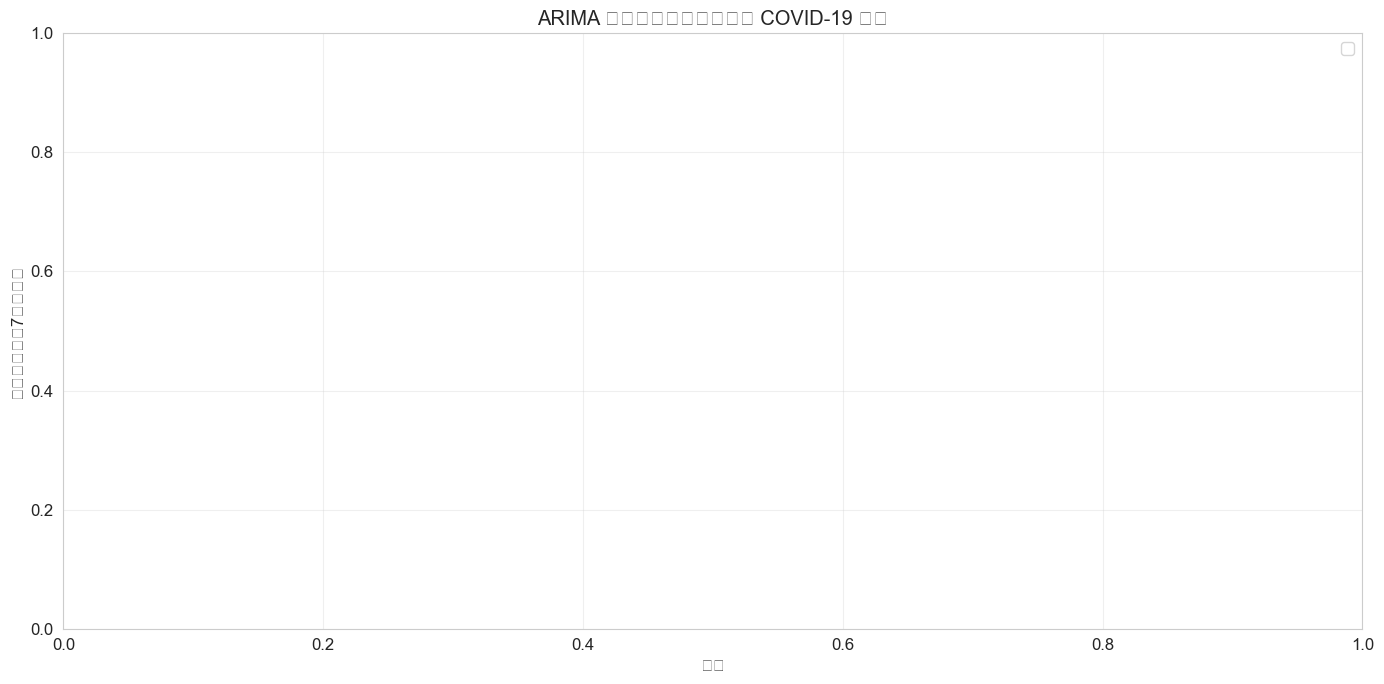

In [60]:
# 尝试预测未来30天
future_forecast = forecast_future(results, steps=30)

# 创建未来日期索引
last_date = ts_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

# 可视化未来预测
plt.figure(figsize=(14, 7))

# 绘制历史数据

plt.title('ARIMA 模型预测美国每日新增 COVID-19 病例')
plt.xlabel('日期')
plt.ylabel('新增病例数（7日平均）')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



## 6. 结论与发现

通过对 COVID-19 时间趋势和模式的分析，我们得出以下主要发现：

1. **时间趋势**：COVID-19 的传播在全球呈现出明显的波动趋势，大多数国家经历了多次疫情高峰。
   
2. **季节性模式**：数据表明 COVID-19 感染确实表现出季节性特征，冬季月份在北半球国家通常有更高的感染率。
   
3. **半球差异**：北半球和南半球的季节性趋势存在相反的模式，这进一步证实了 COVID-19 传播的季节性影响。
   
4. **预测可能性**：ARIMA 等时间序列模型能够在一定程度上预测短期内的 COVID-19 病例趋势，但长期预测的准确性仍受限于多种因素，如政策变化、新变种出现和疫苗接种率等。

这些发现对于公共卫生决策和资源分配具有重要意义，有助于更好地应对未来可能出现的疫情高峰。